# Organic matter decomposition kinetics and potential carbon sequestration in cranberry agroecosystems 

*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [1]:
print(Sys.Date())

[1] "2020-09-04"


## 1. Objective

This notebook generates the results included in the manuscript *Organic matter decomposition kinetics and potential carbon sequestration in cranberry agroecosystems*. Two trials have been made, first one in 2017 (data.csv) and the second in 2018 (data_fractal.csv).Data set from trials are a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study was to assess soil carbon sequestration capacity of cranberry stands in eastern Canada.

## 2. Statistical questions

In addition to data exploration, this notebook will answer the following statistical questions.

1. What's affecting 1st order kinetics?
2. What affecting TBI parameters (k)?
3. Where cranberry soils are placed among the axes of the *TBI*?
4. What is the fractal kinetics of litter matterials ?
5. What is the fractal kinetics of litter biochemical composition ?

## 3. Packages and Function

### 3.1 Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation (e.g. [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (e.g. [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting nonlinear mixed-effects models, the broom package summarises model outputs in a "tidy" way, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) to test distributions, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) to avoid text overlaping on ggplot2, [patchwork](https://www.rdocumentation.org/packages/patchwork/versions/1.0.0/topics/patchwork-package) to assemble plots in grids, [composition](https://www.rdocumentation.org/packages/compositions/versions/1.40-5) for compositional data transformations.

In [2]:
library("tidyverse")
library("nlme")
library("broom")
library("e1071")
library("ggmap")
library("ggrepel")
library("compositions")
library("patchwork")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default




## 3.2 Some custom functions.
### Pseudo R-square
Pseudo R-square allows to measure how well variables of our model explain organic matter decomposition

In [3]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## 4. Import data
Here, we load our data `data.csv` available for the project in the `data` folder.

In [4]:
df <- read_csv("data/data.csv")

Parsed with column specification:
cols(
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)



We create a label `Dose repetition` to create unique identifiers for blocks.

In [5]:
df$`Dose repetition` <- paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

*Cranberry litter* category will be used for the reference category in modeling.

In [6]:
df$`Tea type` <- relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## 5. Mapping experimental sites

We design a map of our four experimental sites with geographical position collected from Stamen maps. Warnings appear, but it seems its a bug that comes out when mixing ggmap and geom_label_repel.

In [7]:
# table including sites and their geograhic position
sites <- tibble(names = c("Fortier/45", "Fortier/9", "Belanger/A9", "Belanger/10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

# create two frames, one for zoom out, the other for zoom in
frame_map_zoom_out <- c(left = -90, bottom = 44, right = -53, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -70.5, top = 47)

# to draw the zoom in frame on the zoom out map
rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))

# the map with zoom out
map_out <- get_stamenmap(frame_map_zoom_out, zoom = 4, maptype = "toner-lite") %>%
  ggmap() +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top,
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  #geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
  labs(x = "Longitude", y = "Latiude", title = "A")

# the map with zoom in
map_in <- get_stamenmap(frame_map_zoom_in, zoom = 8, maptype = "toner-lite") %>%
  ggmap() +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
  labs(x = "Longitude", y = "Latiude", title = "B")

# combining the plots
maps_ <- map_out + map_in

ggsave("figures/site_map.png", plot = maps_, width = 8, height = 6, dpi = 600)

Source : http://tile.stamen.com/toner-lite/4/4/4.png

Source : http://tile.stamen.com/toner-lite/4/5/4.png

Source : http://tile.stamen.com/toner-lite/4/4/5.png

Source : http://tile.stamen.com/toner-lite/4/5/5.png

Source : http://tile.stamen.com/toner-lite/8/76/90.png

Source : http://tile.stamen.com/toner-lite/8/77/90.png

Source : http://tile.stamen.com/toner-lite/8/76/91.png

Source : http://tile.stamen.com/toner-lite/8/77/91.png

Warning message in min(x):
“aucun argument trouvé pour min ; Inf est renvoyé”
Warning message in max(x):
“aucun argument pour max ; -Inf est renvoyé”
Warning message in min(x):
“aucun argument trouvé pour min ; Inf est renvoyé”
Warning message in max(x):
“aucun argument pour max ; -Inf est renvoyé”


## 6. Monthly weather data (2008-2018) at Lemieux, Quebec (46° 09′ 56″ N 72° 19′ 28″ W), for experimental sites (Gouvernement du Canada, 2018)

### 6.1 Import data weather

`Data weather` has been collected from environnement canada. The content is the collection of data history about temperature and precipitation from years of field trial (2017 and 2018) and 10 years average (2008 to 2018).

In [8]:
df_weather <- read_csv2("data/data_weather.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  Years = col_character(),
  Months = col_character(),
  `Precipitations(mm)` = col_double(),
  `Temperatures(oC)` = col_double()
)



### 6.2 Plot weather data

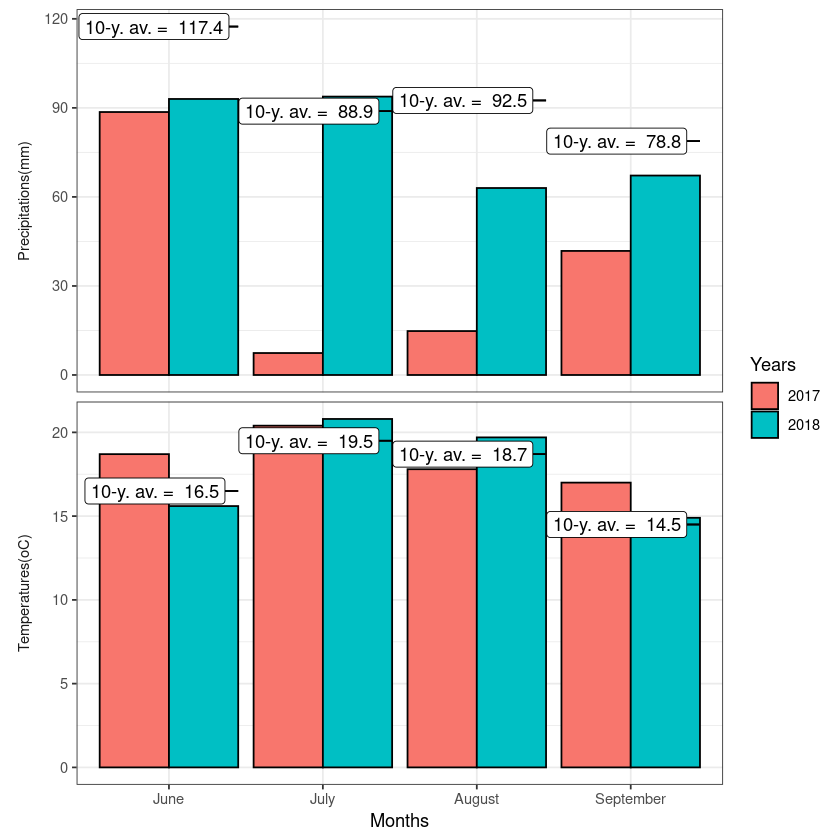

In [9]:
df_weather$Months <- factor(df_weather$Months,levels = c("June", "July", "August", "September")) #  Sorting bars by Months

df_weather_long <- df_weather %>%
  pivot_longer(cols = -c(Years, Months))

Weather <- df_weather_long %>%
  filter(Years %in% c("2017", "2018")) %>%
  ggplot(aes(x = `Months`, y = value)) +
  facet_grid(name ~ ., scales = "free", switch = "y") +
  geom_bar(aes(fill= Years), colour = "black", stat="identity", position="dodge") +
  geom_errorbar(data = df_weather_long %>% filter(Years == "10 Years average"),
                mapping = aes(x = `Months`, ymax = value, ymin = value)) +
  geom_label(data = df_weather_long %>% filter(Years == "10 Years average"),
            mapping = aes(label = paste("10-y. av. = ", value), hjust = 0.6, vjust = 0.5)) +
  #scale_fill_brewer(palette = "Set2") +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        strip.background = element_rect(fill = "transparent", colour = "transparent"),
        strip.placement = "outside")
Weather
ggsave("figures/Weather.png", plot = Weather, width = 7, height = 8, dpi = 120)

## 7. Compute the 1st order kinetics

Weight loss rate has been estimated with the function

$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$,

where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [10]:
kinetics_1st <- function(rw, iw, t) { # First order kinetic function
    -log(rw/iw)/t
}

We can compute `k1` for each row of the `df` table.

In [11]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## 8. Data exploration

Boxplot of $k_1$ for different N dosages per litter.

Warning message:
“Removed 49 rows containing non-finite values (stat_boxplot).”


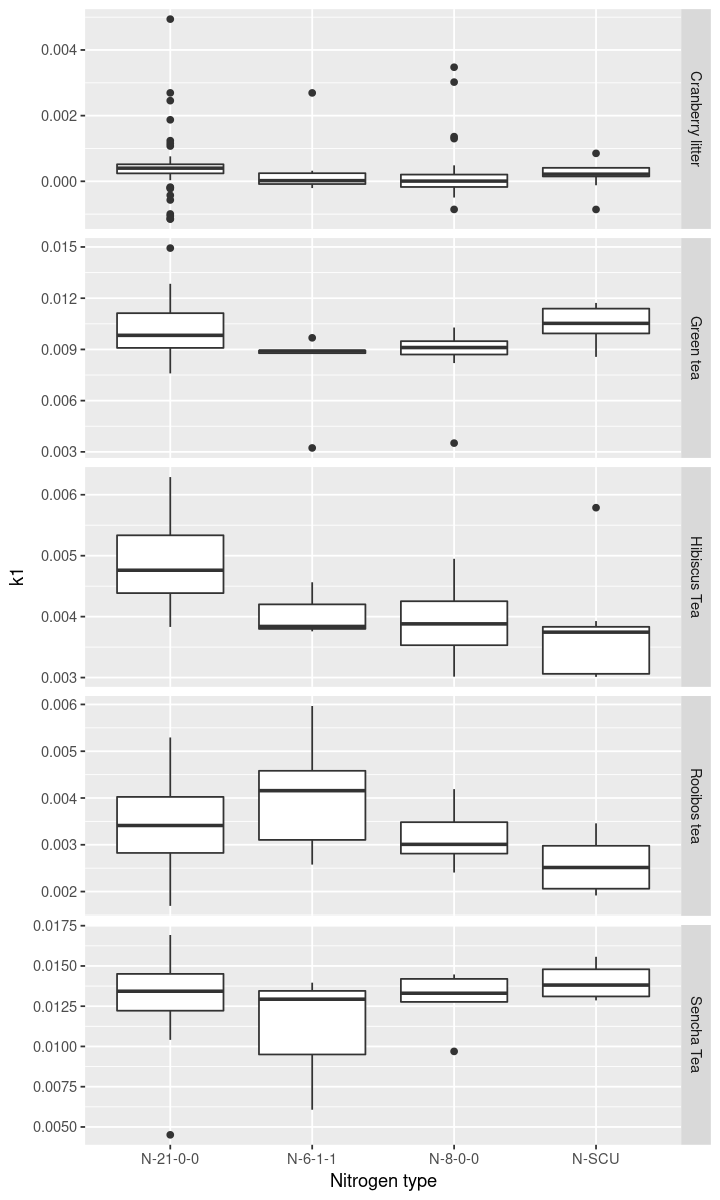

In [12]:
options(repr.plot.width = 6, repr.plot.height = 10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## 9. Mixed model

## 9.1 **Question 1**: What's affecting 1st order kinetics?

The dose is standardized to zero mean and unit variance.

In [13]:
df <- df %>%
  mutate(`Nitrogen dose scaled` = scale(`Nitrogen dose`))

We rename variables without special characters to avoid errors, make sure litters and N dose types are categories, remove NAs in the table and remove categories that might still be in the description but now removed from the table, just in case.

In [14]:
df_mm <- df %>%
  rename(tea = `Tea type`,
         Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose scaled`) %>%
  mutate(tea = factor(tea),
         Ntype = factor(Ntype)) %>%
  drop_na() %>%
  droplevels()

The model investigates the effect of the type of the dose (`Ntype`), the magnitude of the dose (`Ndose`) and the litter (`tea`) on `k1`, considering the random effect of sites (`Site`) nested in farms (`Farm`).

In [15]:
k1_mm <- lme(fixed = k1 ~ Ntype + Ndose * tea,
                     random = ~ 1 | Farm/Site,
                     data = df_mm)
intervals(k1_mm, level = 0.95)

Approximate 95% confidence intervals

 Fixed effects:
                              lower          est.         upper
(Intercept)           -9.462867e-04  1.239460e-04  1.194179e-03
NtypeN-6-1-1          -3.665067e-04  3.700600e-04  1.106627e-03
NtypeN-8-0-0          -1.743344e-04  6.346773e-04  1.443689e-03
NtypeN-SCU            -3.796485e-04  4.694762e-05  4.735438e-04
Ndose                 -4.208416e-05  1.652000e-04  3.724841e-04
teaGreen tea           9.339280e-03  9.623520e-03  9.907760e-03
teaHibiscus Tea        2.407130e-03  3.666305e-03  4.925480e-03
teaRooibos tea         2.814488e-03  3.098233e-03  3.381978e-03
teaSencha Tea          1.174453e-02  1.300483e-02  1.426513e-02
Ndose:teaGreen tea    -5.759245e-04 -2.997410e-04 -2.355746e-05
Ndose:teaHibiscus Tea -1.100255e-03  2.016249e-04  1.503505e-03
Ndose:teaRooibos tea  -4.628679e-04 -1.901859e-04  8.249616e-05
Ndose:teaSencha Tea   -2.914565e-03 -1.612293e-03 -3.100219e-04
attr(,"label")
[1] "Fixed effects:"

 Random Effec

### 9.2.1 P-value

In [16]:
anova(k1_mm)

,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,346,90.4160125,0.000000e+00
Ntype,3,346,9.2429558,6.765238e-06
Ndose,1,346,0.4951917,4.820938e-01
tea,4,346,1309.7300660,0.000000e+00
Ndose:tea,4,346,2.4427906,4.649435e-02


### 9.1.2 Pseudo r-square
Pseudo r-square was high with(0.94) and without(0.91) random effect indicated the influence of random effects was not impotant. Moreover, pseudo r-square was high, indicated mixed model was well fit to data.   

In [17]:
pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 0))

pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 2))

[1] 0.9179987

[1] 0.9405054

### 9.1.3 Shapiro-Wilk normality test

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.93463, p-value = 1.636e-11

[1] "Kurtosis: 4.72510117264426"
[1] "Skewness: 0.0203685029391166"


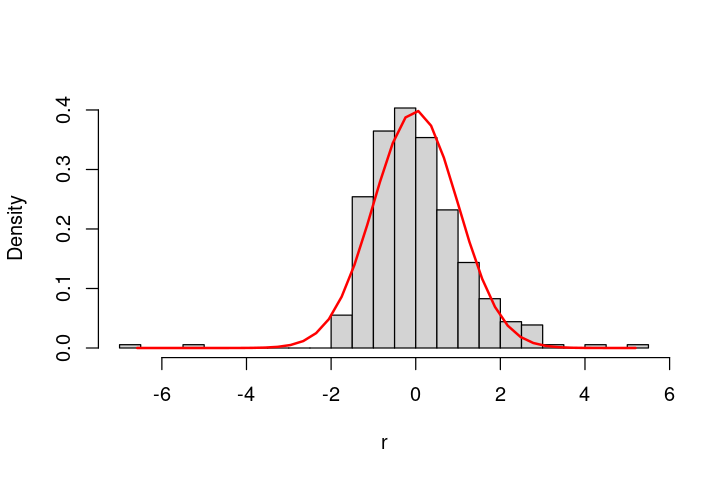

In [18]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(k1_mm)

### 9.1.4 Reporting the results of the mixed models

I create a table including the results I need: estimates, confidence intervals and p-values.

In [19]:
k1_gg <- data.frame(intervals(k1_mm, which = "fixed")$fixed)
k1_gg <- k1_gg %>%
  mutate(variable = rownames(k1_gg))
k1_gg <- k1_gg %>%
  mutate(pvalue = summary(k1_mm)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

k1_gg$variable <- c("Intercept", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0", # Ajust names
                    "Dose N (scaled)", "Green tea", "Hibiscus tea", "Rooibos tea", "Sencha tea",
                     "Green tea : Dose N", "Hibiscus tea : Dose N", "Rooibos tea : Dose N", "Sencha tea : Dose N")

Adding random effects to the table.

In [20]:
k1_re <- data.frame(matrix(ncol = ncol(k1_gg), nrow = 6))
names(k1_re) <- names(k1_gg)
k1_re$est. <- c(ranef(k1_mm)$Farm[, 1], ranef(k1_mm)$Site[, 1])
k1_re$variable <- c(rownames(ranef(k1_mm)$Farm),
                    rownames(ranef(k1_mm)$Site))

if (!("Belanger" %in% k1_gg$variable)) k1_gg <- bind_rows(k1_gg, k1_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [21]:
k1_gg$facet <- factor(c('Intercept',
                        'N source', 'N source', 'N source',
                        "N dosage",
                        'Tea type', 'Tea type', 'Tea type', 'Tea type',
                        'Tea type × N dosage', 'Tea type × N dosage', 
                        'Tea type × N dosage', 'Tea type × N dosage',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

k1_gg <- k1_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "Tea type × N dosage", "Tea type", "N dosage", "N source"))))

The `k1_gg` table is now set up for the plot.

In [22]:
head(k1_gg)

,lower,est.,upper,variable,pvalue,is_significant,facet
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<fct>
1,-9.462867e-04,1.239460e-04,0.0011941787,Intercept,8.199484e-01,Not significant at 0.05 level,NA
2,-3.665067e-04,3.700600e-04,0.0011066268,N 6-1-1,3.237618e-01,Not significant at 0.05 level,N source
3,-1.743344e-04,6.346773e-04,0.0014436891,N 8-0-0,1.237430e-01,Not significant at 0.05 level,N source
4,-3.796485e-04,4.694762e-05,0.0004735438,N SCU-39-0-0,8.287611e-01,Not significant at 0.05 level,N source
5,-4.208416e-05,1.652000e-04,0.0003724841,Dose N (scaled),1.179067e-01,Not significant at 0.05 level,N dosage
6,9.339280e-03,9.623520e-03,0.0099077596,Green tea,2.294593e-199,Significant at 0.05 level,Tea type


Warning message:
“Removed 6 rows containing missing values (geom_segment).”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”


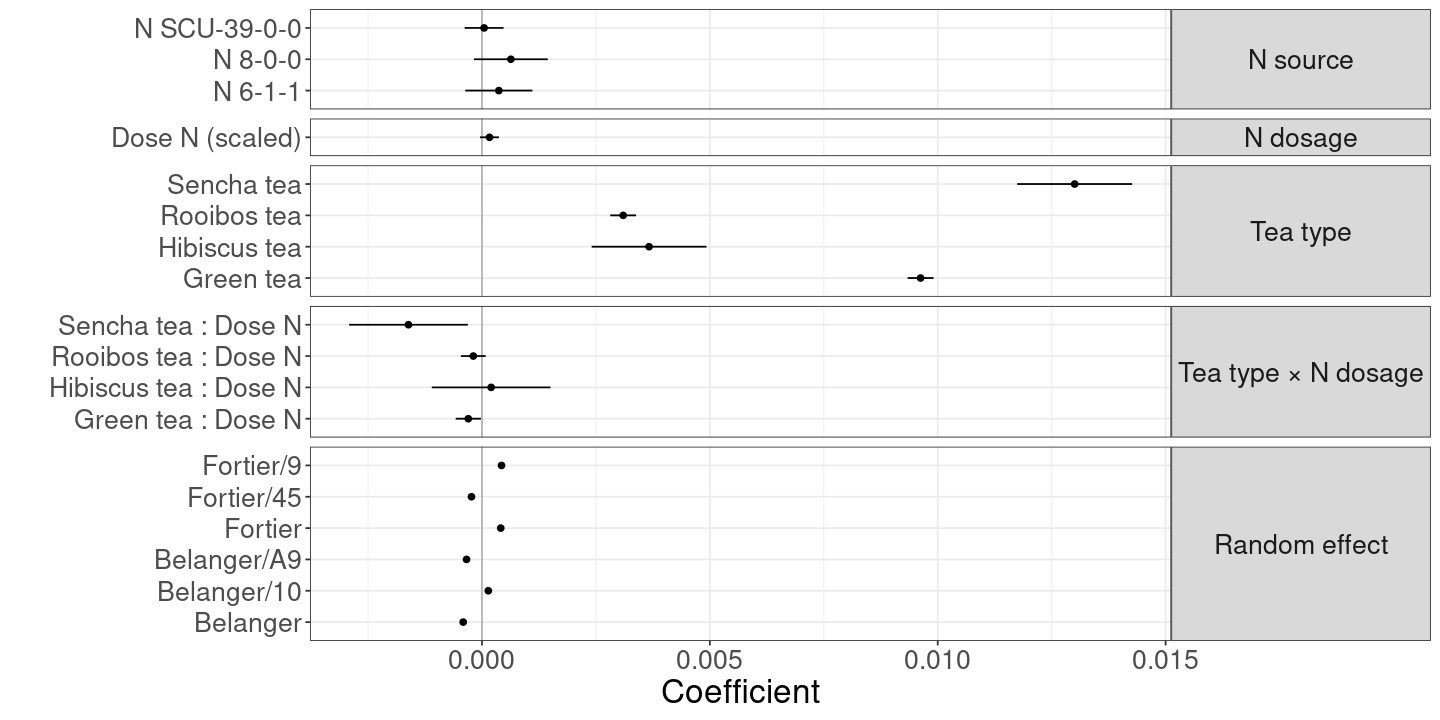

In [23]:
options(repr.plot.width = 12, repr.plot.height = 6)
k1_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/mixed-model-coefficients.png", width = 8, height = 6, dpi = 600)

How did $k_1$ react across tea types and nitrogen sources for a range of doses, according to the model? To answer this question, I create a grid of values and categories, predict the model for each row of the grid, then put nitrogen dosage back to its original scale.

In [24]:
pred_grid <- expand.grid(tea = unique(df_mm$tea),
                         Ndose = c(min(df_mm$Ndose), max(df_mm$Ndose)),
                         Ntype = unique(df_mm$Ntype))
pred_grid <- pred_grid %>%
  mutate(k1 = predict(k1_mm, newdata = pred_grid,
                              level = 0),
         Ndose = Ndose * sd(df$`Nitrogen dose`) + mean(df$`Nitrogen dose`)) %>%
  rename(`Tea type` = tea,
         `Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [25]:
pred_grid %>% sample_n(10)

Tea type,Nitrogen dose,Nitrogen type,k1
<fct>,<dbl>,<fct>,<dbl>
Cranberry litter,6.000000e+01,N-21-0-0,0.0003457579
Rooibos tea,3.552714e-15,N-6-1-1,0.0036305203
Green tea,6.000000e+01,N-8-0-0,0.0102014965
Green tea,3.552714e-15,N-21-0-0,0.0099535976
Cranberry litter,6.000000e+01,N-SCU,0.0003927055
Sencha Tea,6.000000e+01,N-SCU,0.0112327261
Hibiscus Tea,6.000000e+01,N-8-0-0,0.0049174591
Rooibos tea,6.000000e+01,N-8-0-0,0.0038233082
Sencha Tea,6.000000e+01,N-8-0-0,0.0118204558


This table allows to plot the model and data superimposed.

Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


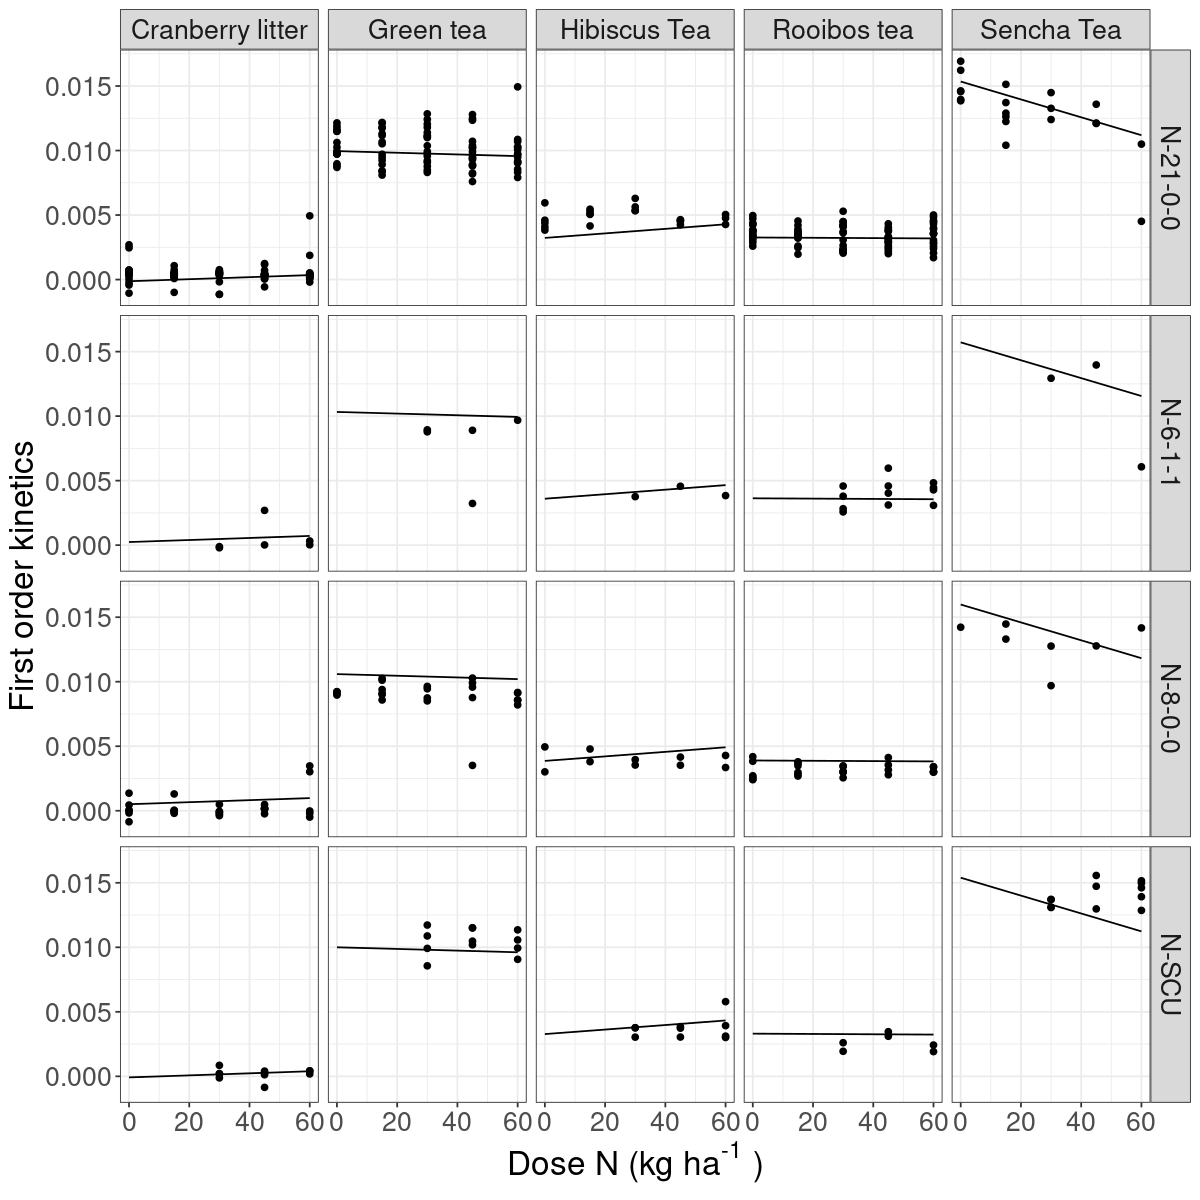

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df, aes(x = `Nitrogen dose`, y = `k1`)) +
  facet_grid(`Nitrogen type` ~ `Tea type`) +
  geom_point() +
  geom_line(data = pred_grid) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "First order kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20)) + 
  ggsave("figures/k1-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

## 9.2 **Question 2**: What affected TBI parameters (k)?

Adding `M / M0` variable to data `df`.

In [27]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

I store hydrolysable fractions of green tea and rooibos.

In [28]:
Hf_g <- 0.805   # Hydrolysable fraction for Green tea
Hf_r <- 0.826   # Hydrolysable fraction for Rooibos tea

For comparaison purpose, [Keuskamp et al. (2013)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12097) hydrolysable fractions were:

- Green tea `Hf_g = 0.842`  
- Rooibos tea `Hf_r = 0.552`

### 9.2.1 Computation of the labile fraction (a) and the stabilization factor (s) of green tea

Decomposition rate `k_tbi` is computed from Rooibos tea after 90 days of incubation. The *TBI* assumes that the decomposition of Green tea has stablilized while Rooibos tea is still decomposing. Stabilization factor `S` is computed from Green tea.

In [29]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

Compute litter stability `Sg` (Green tea) and decomposition constant `k_tbi` (Rooibos) for each experimental unit.

In [30]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

In [31]:
# Initialize k_tbi column
df$k_tbi <- NA

# For each rep, compute a and k_tbi
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

Data exploration for N dose type.

`summarise()` regrouping output by 'Nitrogen dose' (override with `.groups` argument)

Warning message:
“Removed 388 rows containing missing values (geom_point).”


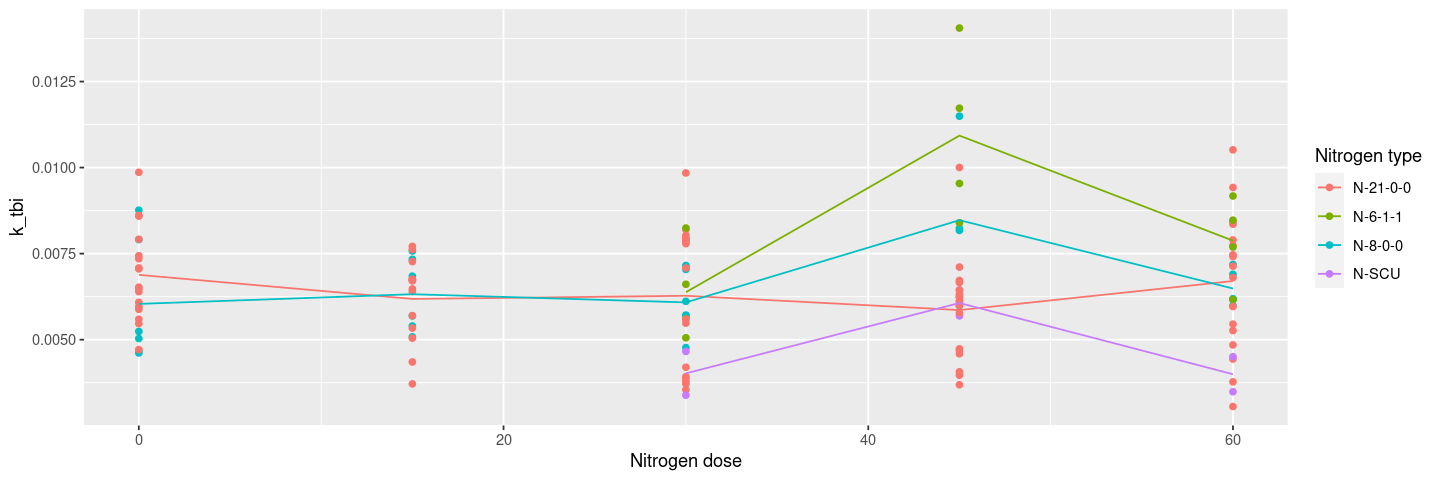

In [32]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data = df,
       mapping = aes(x = `Nitrogen dose`, y = k_tbi)) +
  geom_point(aes(colour = `Nitrogen type`)) +
  geom_line(data = . %>%
    group_by(`Nitrogen dose`, `Nitrogen type`) %>%
    summarise(k_tbi = mean(k_tbi, na.rm = TRUE)),
           aes(colour = `Nitrogen type`))

### 9.3 What affecting TBI parameters (k)?

Because `k_tbi` is computed from Rooibos tea, we create a new Rooibos data table named `df_rooibos`.

In [33]:
df_rooibos <- df %>% 
  filter(`Tea type` == "Rooibos tea")

TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

### 9.3.1 `k_tbi` mixed model

lme_TBI model investigates the effect of the type of the dose (`Ntype`), the magnitude of the dose (`Ndose`) on `k_tbi`, considering the random effect of sites (`Site`) nested in farms (`Farm`).

In [34]:
lme_TBI <- lme(fixed = k_tbi ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = TBI_rooibos)

In [35]:
summary(lme_TBI)$tTable # Get p-values

,Value,Std.Error,DF,t-value,p-value
(Intercept),6.164356e-03,8.636613e-04,120,7.1374693,7.871002e-11
Ndose,3.116282e-06,6.663922e-06,120,0.4676347,6.408939e-01
NtypeN-6-1-1,2.000522e-03,5.863409e-04,120,3.4118758,8.799726e-04
NtypeN-8-0-0,6.682900e-04,6.995885e-04,120,0.9552616,3.413659e-01
NtypeN-SCU,-4.075112e-04,6.884892e-04,120,-0.5918920,5.550364e-01


### 9.3.2 Mixed model graphic

> SÉP. Expliques ce que tu fais.

In [36]:
ktbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
ktbi_gg <- ktbi_gg %>%
  mutate(variable = rownames(ktbi_gg))
ktbi_gg <- ktbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [37]:
ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

Add random effects to the table.

In [38]:
ktbi_re <- data.frame(matrix(ncol = ncol(ktbi_gg), nrow = 6))
names(ktbi_re) <- names(ktbi_gg)
ktbi_re$est. <- c(ranef(lme_TBI)$Farm[, 1], ranef(lme_TBI)$Site[, 1])
ktbi_re$variable <- c(rownames(ranef(lme_TBI)$Farm),
                    rownames(ranef(lme_TBI)$Site))

> SÉP. Expliques ce que tu fais.

In [39]:
if (!("Belanger" %in% ktbi_gg$variable)) ktbi_gg <- bind_rows(ktbi_gg, ktbi_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [40]:
ktbi_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

ktbi_gg <- ktbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept")))) # reorder facets for ploting

Fire the plot!

Warning message:
“Removed 6 rows containing missing values (geom_segment).”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”


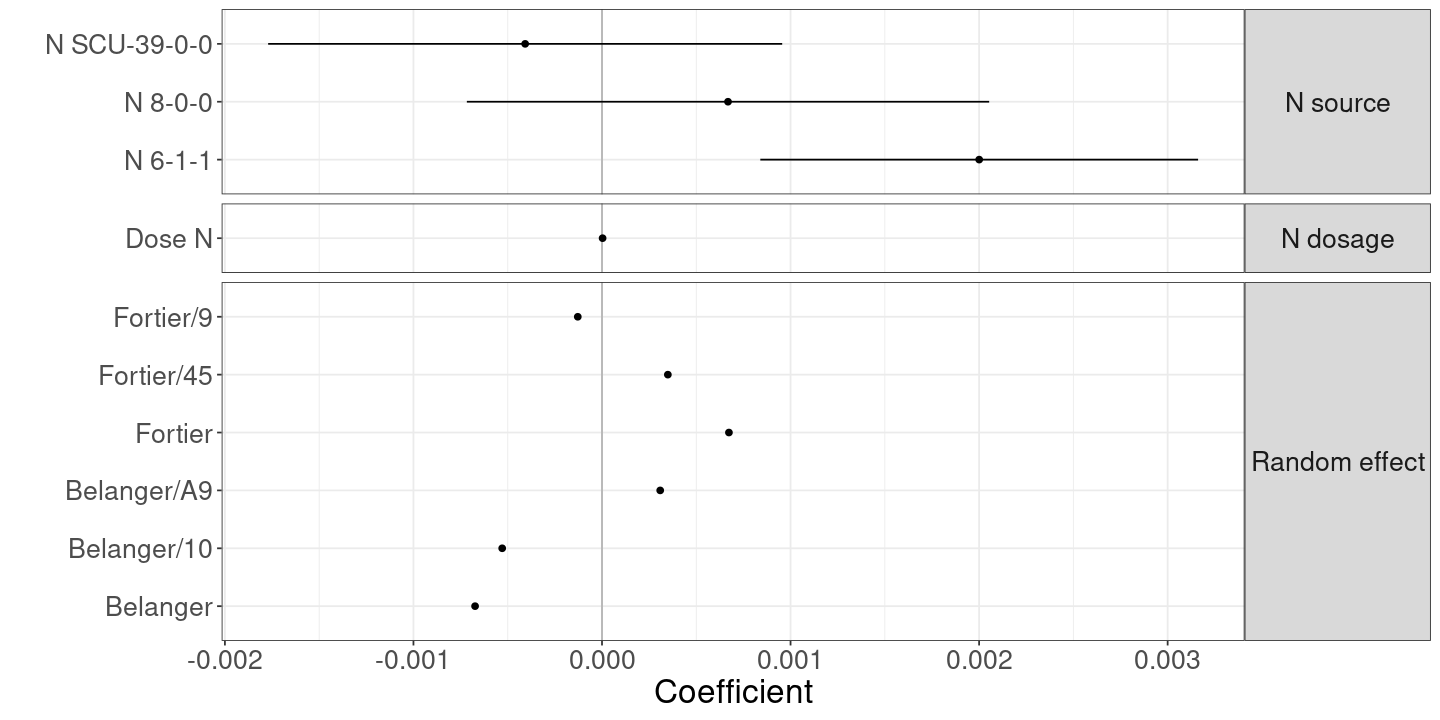

In [41]:
options(repr.plot.width = 12, repr.plot.height = 6)

ktbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/ktbi-lme-effects.png", width = 8, height = 5, dpi = 600)

## 10. Litters biochemical composition balance

> SÉP. Expliques ce à quoi cette section est vouée.

### 10.1 Import data

> SÉP. Quelques mots sur les données que tu importes. Quelles sont-elles?

In [42]:
data_fiber <- read_csv('data/data_fiber_initial.csv')

Parsed with column specification:
cols(
  `Biomass type` = col_character(),
  `SOL perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double()
)



### 10.2 Isometic log ratio (Ilr)

> SÉP. Expliques ce que tu fais!

I isolate the parts of the compostion in table then, with `acomp`, make sure that all rows are summing to 1.

In [43]:
TeaCompositionComp <- acomp(
    data_fiber %>%
      select(`LIC perc initial (%)`, `SOL perc initial (%)`,  `HOLO perc initial (%)`)
)

I create a sewuential binary partition that serves as a basis for the balance system .

In [44]:
TeaCompositionSBP <- matrix(c(-1, 1, 1,
                               0, 1,-1),
                            byrow = TRUE,
                            ncol = 3)
colnames(TeaCompositionSBP) <- c('Lignine', 'Soluble', 'Holocelulose')

The 3 components are transformed to 2 balances based on the SBP.

In [45]:
TeaCompositionBal <- ilr(TeaCompositionComp, V = gsi.buildilrBase(t(TeaCompositionSBP)))

These balances are added to the `data_fiber` table.

In [46]:
data_fiber$TeaComposition_L.HS <- TeaCompositionBal[, 1] # ilr1 [Lignin | Soluble.Holocelulose]
data_fiber$TeaComposition_S.H <- TeaCompositionBal[, 2] # ilr2 [Soluble | Holocelulose]

### Plot of classification of litters using balances among biochemical components

> SÉP. Expliques ce que tu fais!

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



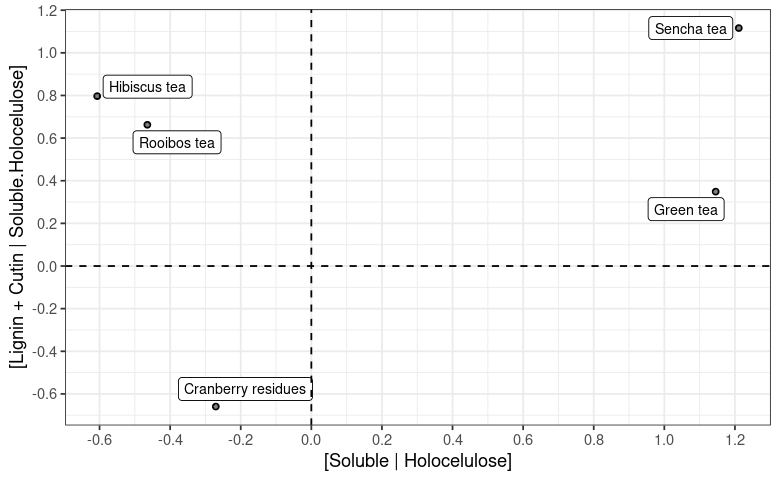

In [47]:
options(repr.plot.width = 6.5, repr.plot.height = 4)
ggplot(data_fiber, aes(x =  `TeaComposition_S.H`, y = `TeaComposition_L.HS`)) +
geom_point()+
geom_label_repel(aes(label = `Biomass type`), size = 3) +
labs(x = "[Soluble | Holocelulose]" , y = "[Lignin + Cutin | Soluble.Holocelulose]") +
theme(axis.title.x = element_text(size = 14), axis.title.y = element_text(size = 14)) +
xlim(-1.5, 1.5) +
scale_y_continuous(breaks=seq(-2,2,0.2)) + 
scale_x_continuous(breaks=seq(-2,2,0.2)) +
geom_hline(yintercept = 0, linetype = "dashed") +
geom_vline(xintercept = 0, linetype = "dashed") +
theme_bw() +
geom_point(size = 1, alpha = 0.5, pch = 21, fill = "white") 
ggsave("figures/Classification of litters using balances among biochemical components.png", width = 6.2, height = 4, dpi = 120)

## 11. **Question 3**: Where cranberry soils are placed among the axes of the *TBI*?

> SÉP. Expliques ce que tu fais!

### 11.1 Import data

We adapted keuskamp's TBI by adding cranberry ecosystem

In [48]:
df_keuskamp <- read_csv("data/keuskamp_tbi_data.csv")# Import Keuskamp data

Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)



In [49]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

### 11.2 Figure TBI_ Keuskamp

> SÉP. Expliques ce que tu fais!

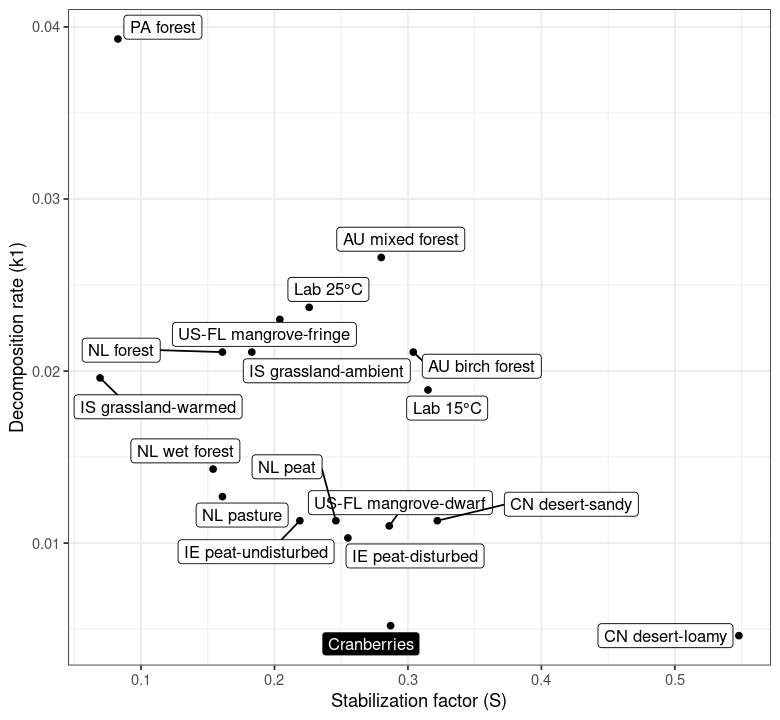

In [50]:
options(repr.plot.width = 6.5, repr.plot.height = 6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Stabilization factor (S)", y = "Decomposition rate (k1)") +
  ggsave("figures/TBI_keuskamp.png", width = 6, height = 6, dpi = 120)

### 12. **Question 4**:What is the fractal kinetics of litter matterials ?

Depending on the nature of decaying material and its immediate environment, the decomposition rate of plant residues can decrease gradually through time as follow: 

$$k_t = k_1 t^{{-h}}$$

$$log \left( k_t \right) = log \left( k_1 t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) + log \left(t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) - h \times log \left(t\right)$$

Where $k_t$ is first order kinetics, $k_1$ is reaction rate at time t = 1 and $h$ is a fractal coefficient (0 ≤ h ≤ 1) accounting for the decreasing decomposition rate through time

#### 12.1 Fractal coefficient computation

##### 12.1.1 Import data

> SÉP. Expliques ce que tu fais!

In [51]:
data_fractal <- read_csv2("data/data_fractal.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)



##### 12.1.1 Adding some variables
`First order kinetic names (k)`, `log(k)` and `Log(t)` has been computed. `Filter(k>0)` has been added to be able to compute the logarithme `log(k)`. Then we select the variables needed in order compute the fractal coefficient `h`

> SÉP. Expliques ce que tu fais!

In [52]:
data_lm_fractal <- data_fractal %>%
  mutate(
    # time and k
    time = Prelevement * 21,
    k = -log(`Final weight (g)` / `Initial weight (g)`)/ time,
  ) %>%
  filter(k > 0) %>%
  mutate(
    # log.time and log.k
    log.time = log10(time),
    log.k = log10(k)
  ) %>%
  select(`Tea type`, `k`,`log.time`, `log.k`, `time`)

#data_lm_fractal# %>%
 # sample_n(6)

Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [53]:
fractal_kinetics <- tibble(
    tea_types = c("Rooibos tea", "Cranberry litter", "Green tea"),
    intercept = NA,
    slope = NA,
    r_sq = NA
)

```
lm(log.k ~ log.time)
log.k1 = 10^intercept
h = -slope
```


data_lm_fractal %>%
  ggplot(aes(x = log.time, y = log.k)) +
  geom_point() +
  geom_smooth(method = "lm") +
  facet_wrap(~ `Tea type`)

Computation of median value of `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [54]:
data_median_lm_fractal <- aggregate(cbind(log.time, log.k) ~ time + `Tea type`, data = data_lm_fractal, FUN = median)
data_median_lm_fractal

time,Tea type,log.time,log.k
<dbl>,<chr>,<dbl>,<dbl>
21,Cranberry litter,1.322219,-3.106817
42,Cranberry litter,1.623249,-2.798478
63,Cranberry litter,1.799341,-3.717693
84,Cranberry litter,1.924279,-3.421914
105,Cranberry litter,2.021189,-3.105826
126,Cranberry litter,2.100371,-3.023167
147,Cranberry litter,2.167317,-3.013066
21,Green tea,1.322219,-1.631823
42,Green tea,1.623249,-1.849878


Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1` by `tea type`

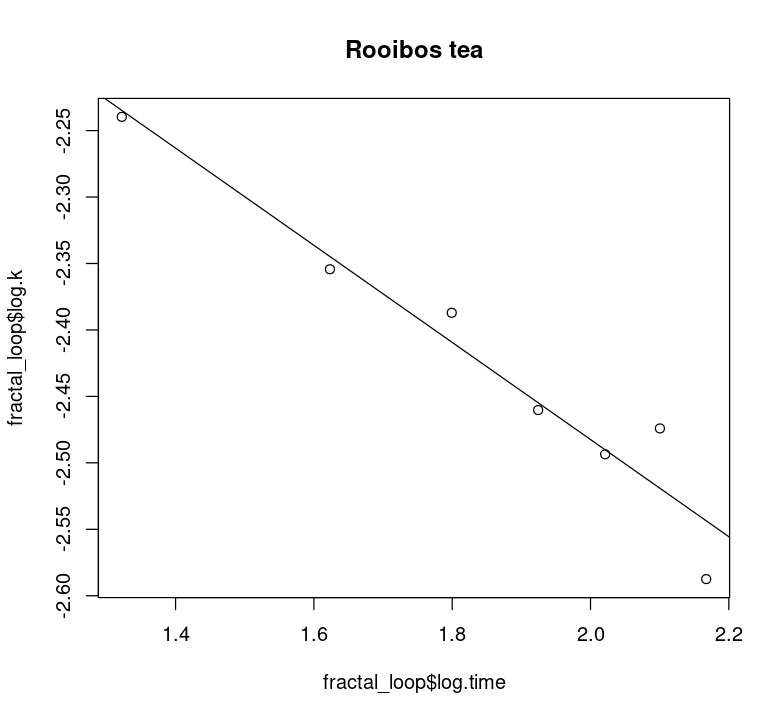

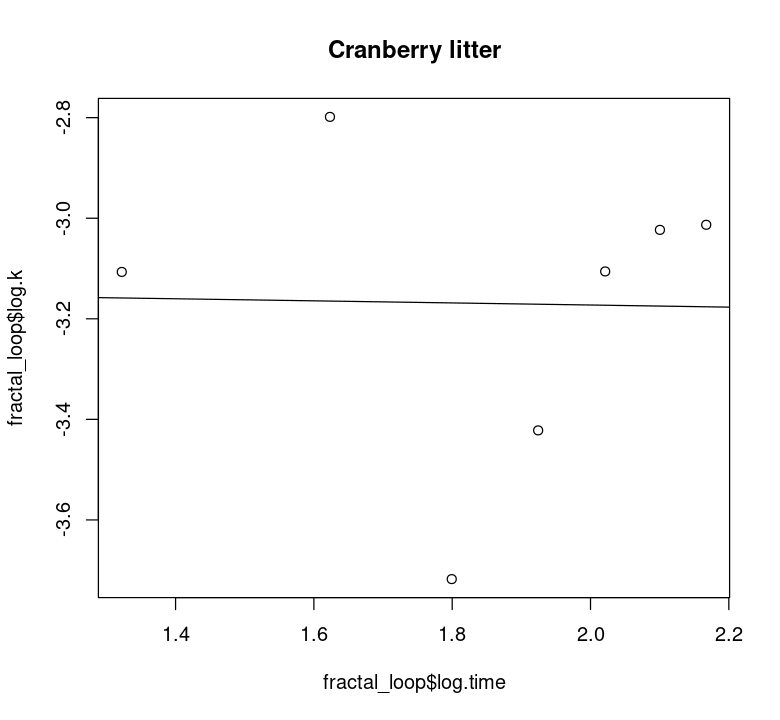

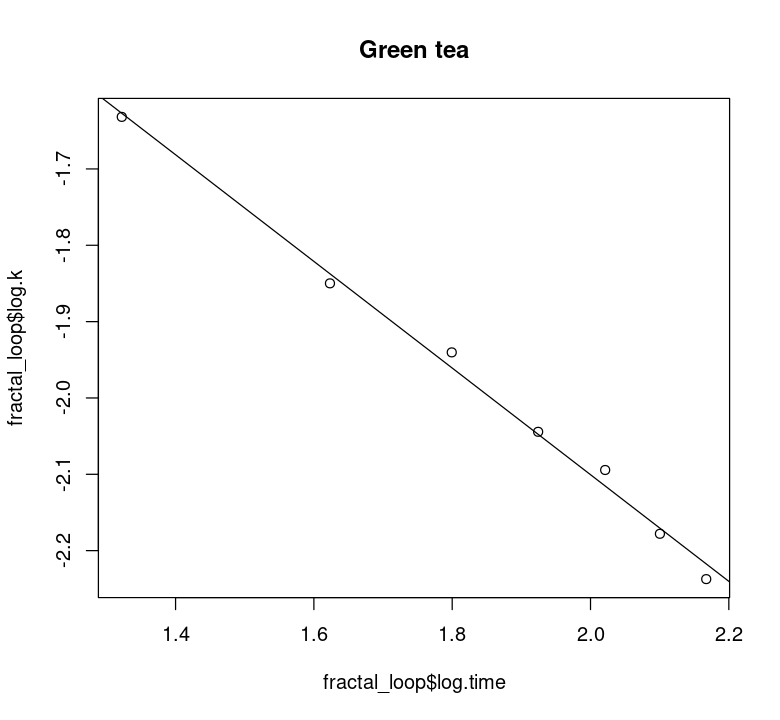

In [60]:

for (i in 1:nrow(fractal_kinetics)) {
    
    fractal_loop <- data_median_lm_fractal %>%
      filter(`Tea type` == fractal_kinetics$tea_types[i])
    
    lm_fractal <- lm(log.k ~ log.time, data = fractal_loop)

    fractal_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared

    plot(fractal_loop$log.time, fractal_loop$log.k,
        main = fractal_kinetics$tea_types[i])
    abline(a = fractal_kinetics$intercept[i], b = fractal_kinetics$slope[i])
    
    
}

#fractal_kinetics

In [63]:
fractal_kinetics <-  fractal_kinetics %>%
  mutate(h = -slope,
         k1 = 10^intercept)
fractal_kinetics

tea_types,intercept,slope,r_sq,h,k1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rooibos tea,-1.7516426,-0.3654122,0.9390858023,0.3654122,0.0177156624
Cranberry litter,-3.1311544,-0.0207501,0.0004111749,0.0207501,0.0007393424
Green tea,-0.7035358,-0.6985075,0.9943128412,0.6985075,0.1979084002


Mean and standard deviation of first order kinetics

In [64]:
data_fractal_mean <- aggregate(cbind(time, `k`) ~ `Tea type`, data = data_lm_fractal, FUN = mean)
data_fractal_mean
data_fractal_sd <- aggregate(cbind(time, `k`) ~ `Tea type`, data = data_lm_fractal, FUN = sd)
data_fractal_sd

Tea type,time,k
<chr>,<dbl>,<dbl>
Cranberry litter,104.15823,0.0008353905
Green tea,81.77885,0.0114839423
Rooibos tea,81.87459,0.0039776542


Tea type,time,k
<chr>,<dbl>,<dbl>
Cranberry litter,32.31796,0.0009684872
Green tea,42.23812,0.0055935476
Rooibos tea,42.69211,0.0014494302


## 12.3.4 Estimation of the carbon decreasing rate of teas and cranberry residue

Reaction rate $k_1$ at time t = 1 and fractal coefficient $h$

In [69]:
k1_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(k1)

k1_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(k1)

k1_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(k1)

h_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(h)

h_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(h)

h_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(h)

Computing  $k_t$ for each tea type and renaming somes variables to be able to group plot

$$k_t = k_1 t^{{-h}}$$

In [70]:
data_rate <- data.frame(Prelevement = 1:7) %>%
                            mutate(`Time (days)` = Prelevement * 21,
                                  `Rate cranberry` = k1_cranberry *  `Time (days)`**-h_cranberry,
                                  `Rate rooibos` = k1_rooibos * `Time (days)`**-h_rooibos,
                                  `Rate green` = k1_green * `Time (days)`**-h_green) %>%
                            rename(`Cranberry litter` = `Rate cranberry`,
                                  `Rooibos tea` = `Rate rooibos`,
                                   `Green tea` = `Rate green`)

Tranforming data_rate into long format data in order to generate the plot

In [71]:
data_long <- gather(data = data_rate, key = `tea type`, value = Rate, c(`Cranberry litter`, `Rooibos tea`, `Green tea`),
                    factor_key=TRUE)
data_long <- data_long %>%
             rename(`Litter type`= `tea type`)

Plot of litter decomposition rate over time under field conditions

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”


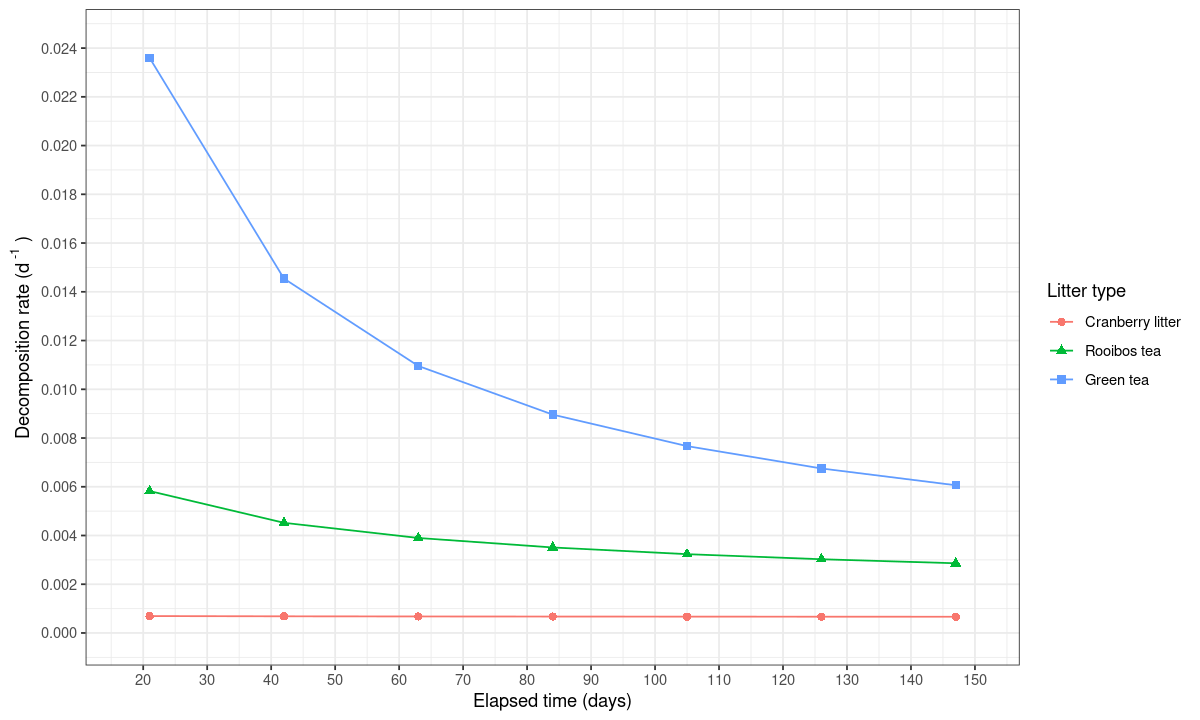

In [72]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x = `Time (days)`, y = `Rate`, group = `Litter type`, color = `Litter type`)) +
geom_line() +
geom_point(aes(shape = `Litter type`), size = 2)+
#geom_smooth(method = "lm", formula = y ~ poly(x, 6) , color = 'grey', se = FALSE) + 
labs(x = "Elapsed time (days)" , y = expression("Decomposition rate (d"^" -1"~")"))  +
theme(axis.title.x = element_text(size = 14), 
  axis.title.y = element_text(size = 14),
     legend.text=element_text(size=14)) +
scale_y_continuous(breaks = 0.002*0:1000,
                     expand = expand_scale(add = 0.002)) +
scale_x_continuous(breaks = 10*0:1000,
                     expand = expand_scale(add = 10)) +
theme_bw() +
ggsave("figures/K(t).png", width = 6, height = 4, dpi = 120)

## 13. **Question 4**: What is the fractal kinetics of litter biochemical composition ?

### 13.1 Biochemical composition data analysis 
Here, we load `data.csv`, `data_fiber_initial.csv` and `data_fiber.csv`available for the project in the `data` folder. The `data_2018.csv` contained incubation tea bag details and soil carateristics from the second essay in 2018; `data_fiber_initial.csv` contained only initial tea bag caracteristics and `data_fiber.csv` contained mostly tea bag biochemical details as soluble, holocellulose and lignin content. 
We wanted to use only data about `green tea`, `rooibos tea` and `cranberry residu`. In order to do that, we used `subset` function to get `data_subset`

In [73]:
data <- read_csv('data/data_2018.csv', col_types = "??????????????f????????????????????")
data_fiber <- read_csv('data/data_fiber.csv')
data_fiber_initial <- read_csv('data/data_fiber_initial.csv')

data_subset <- subset(data,  (`Sampling period (3 weeks)`> 0 & (`Biomass type`== "Cranberry residu" | 
`Biomass type` == "Green tea"| `Biomass type` == "Rooibos tea")))

Parsed with column specification:
cols(
  `Iden fiber` = col_character(),
  `SOL perc ILR (%)` = col_double(),
  `HOLO perc ILR (%)` = col_double(),
  `LIC perc ILR (%)` = col_double()
)

Parsed with column specification:
cols(
  `Biomass type` = col_character(),
  `SOL perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double()
)



Join all 3 data with with `left_join` function. The obtained data is called `data_join_02`

In [74]:
data_join <- data_subset %>%
  left_join(data_fiber, by = 'Iden fiber')

data_join_02 <- data_join %>%
  left_join(data_fiber_initial, by = 'Biomass type')

## 13.2 Some calculations 
### Initial and final content of carbon, soluble, holocellulose and lignin

In [75]:
data_join_02 <- data_join_02 %>%
mutate(`Initial SOL content (g)` = `SOL perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial HOLO content (g)` = `HOLO perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial LIC content (g)` = `LIC perc initial (%)` * `Sample initial weight (g)` / 100,
       `Final SOL content (g)` = `SOL perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final LIC content (g)` = `LIC perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final HOLO content (g)` = `HOLO perc ILR (%)` * `Sample final weight (g)` / 100,
       `Initial Hydrolyzable content (g)` = `Initial SOL content (g)` +  `Initial HOLO content (g)`,
       `Final Hydrolyzable content (g)` = `Final SOL content (g)` + `Final HOLO content (g)`)

### 13.2.1 First order kinetic
Here,we compute decomposition rate of carbon, soluble, holocellulose and lignin using first order kinetic.

In [76]:
kinetics_1st <- function(rw, iw, t) { # first order kinetic function
    -log10(rw/iw)/t
}

In [77]:
data_join_02 <- data_join_02 %>%
mutate(`rate SOL` = kinetics_1st(rw = `Final SOL content (g)`,
                      iw = `Initial SOL content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate HOLO` = kinetics_1st(rw = `Final HOLO content (g)`,
                      iw = `Initial HOLO content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate LIC` = kinetics_1st(rw = `Final LIC content (g)`,
                      iw = `Initial LIC content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate Hydrolyzable` = kinetics_1st(rw = `Final Hydrolyzable content (g)`,
                      iw = `Initial Hydrolyzable content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
      `Sampling period (days)` = `Sampling period (3 weeks)` * 21)

### 13.2.2 Selection all variables we interested in data_join_02. Our final data is called `data_filtre`

In [78]:
na.action = na.exclude
data_filtre <- data_join_02 %>%
select(`Iden fiber`, `Biomass type`,  `Sampling period (days)`, `Site`, `Producer`,`Repetition`,
 `Initial SOL content (g)`, `Initial HOLO content (g)`, `Initial LIC content (g)`, `Final SOL content (g)`,`Final HOLO content (g)`, `Final LIC content (g)`,
       `Sample final weight (g)`, `Initial Hydrolyzable content (g)`, `Final Hydrolyzable content (g)`,
       `rate SOL`, `rate HOLO`, `rate LIC`, `rate Hydrolyzable`) %>% 
rename(Lignin = `rate LIC`, 
       Holocelulose = `rate HOLO`, 
       Soluble = `rate SOL`,
       Hydrolyzable = `rate Hydrolyzable`)

## 13.3 Missing values visualization

Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep




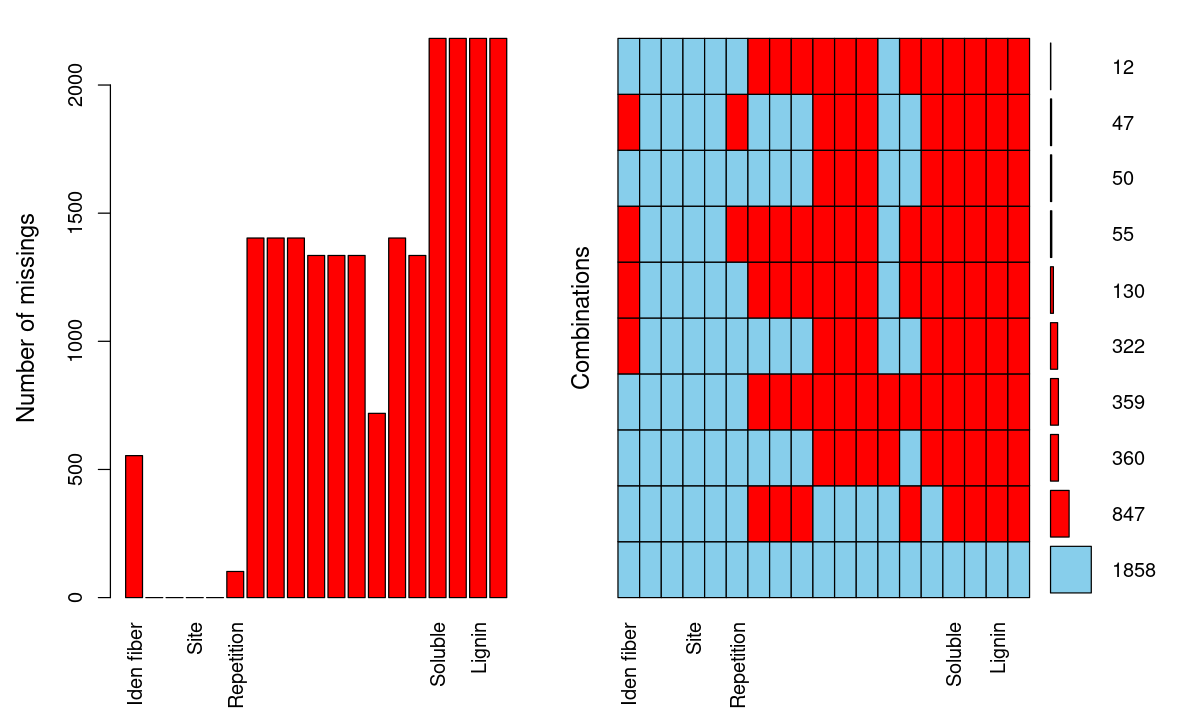

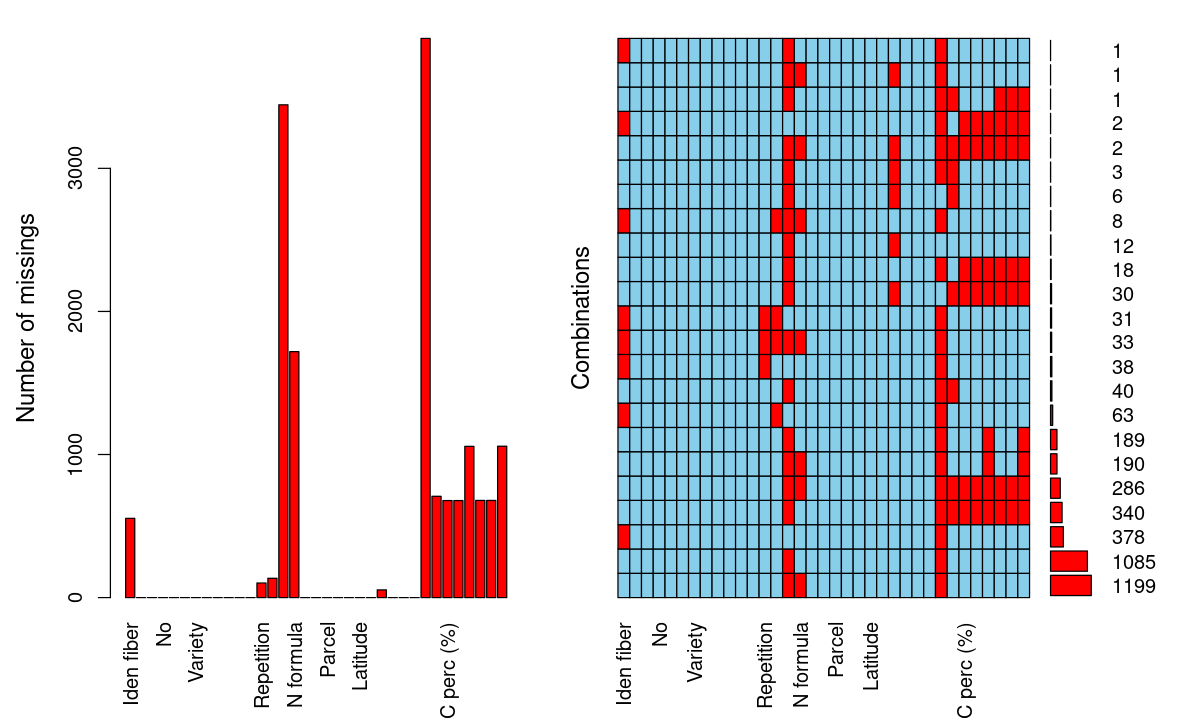

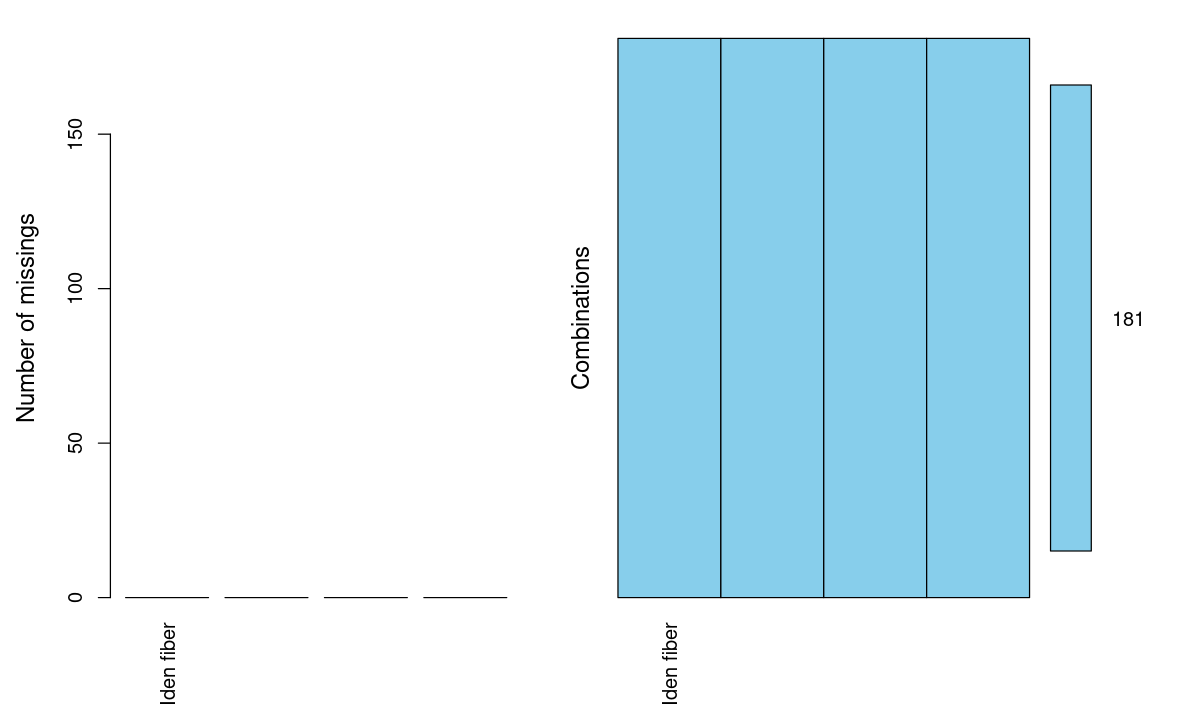

In [79]:
library(VIM)
aggr(data_filtre, numbers = TRUE, prop = FALSE)
aggr(data_subset, numbers = TRUE, prop = FALSE)
aggr(data_fiber, numbers = TRUE, prop = FALSE)


In [80]:
data_filtre_2 <- data_filtre[complete.cases(data_filtre), ]
nrow(data_filtre_2)
nrow(data_filtre)

[1] 1858

[1] 4040

## 13.4 Linear regressions of materials biochemical composition

### 13.4.1 Linear regression of remaining soluble content

In [81]:
data_long <- gather(data = data_filtre, key = `Biochemical composition`, value = `Biochemical decomposition rate`, c(`Soluble`,
                                                                                                                    `Lignin`, `Holocelulose`, `Hydrolyzable`),
                    factor_key=TRUE)

In [82]:
data_long <- subset(data_long, `Biochemical decomposition rate` > 0 & `Biomass type` == "Green tea" | `Biomass type` == "Rooibos tea")
data_long <- subset(data_long, `Biochemical composition` == "Lignin" | `Biochemical composition` == "Hydrolyzable")

In [83]:
data_long <- data_long %>%
        mutate(`log.K` = log10(`Biochemical decomposition rate`),
                `log.T` = log10(`Sampling period (days)`))

Warning message:
“Problem with `mutate()` input `log.K`.
ℹ production de NaN
ℹ Input `log.K` is `log10(`Biochemical decomposition rate`)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“production de NaN”


In [84]:
New.labs <- c("Non-Hydrolyzable", "Hydrolyzsable") # New facet names for variable `Biochemical composition`
names(New.labs) <- c("Lignin", "Hydrolyzable")

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 832 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 832 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 832 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 832 rows containing missing values (geom_point).”


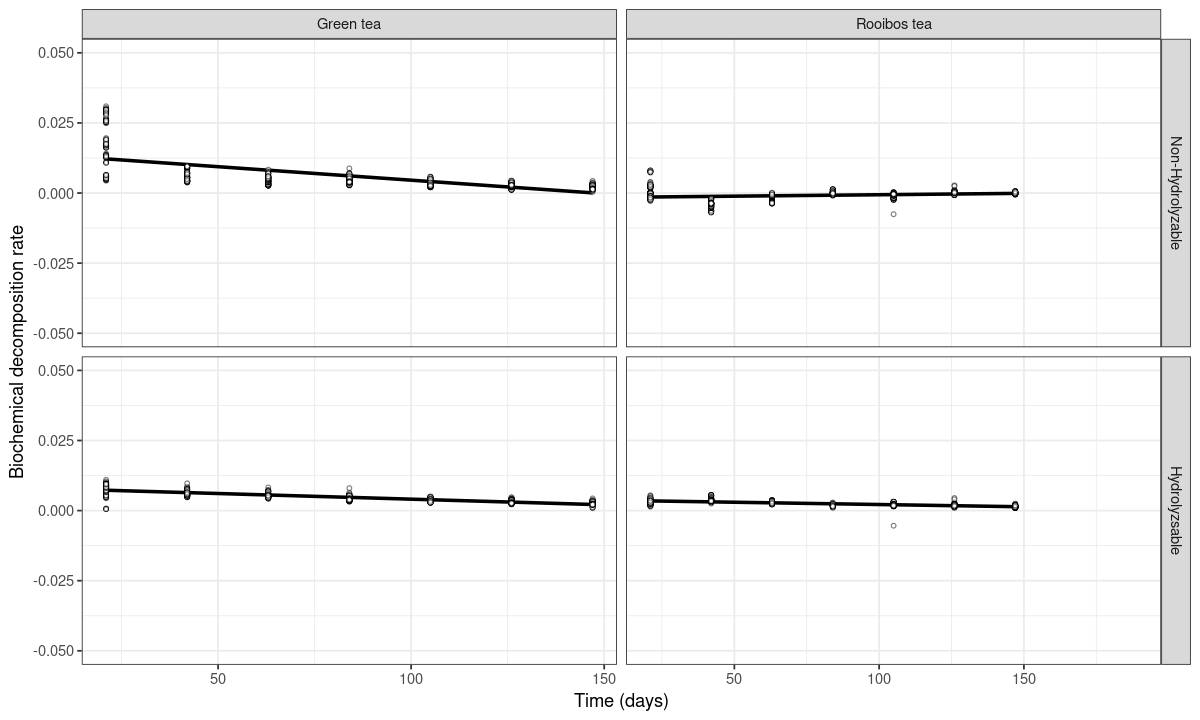

In [85]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x =  `Sampling period (days)`, y = `Biochemical decomposition rate`)) +
#geom_point(aes(shape = `Biomass type`), size = 4)+
facet_grid( `Biochemical composition` ~ `Biomass type`, scales = "free",
           labeller = labeller(`Biochemical composition` = New.labs)) +
geom_smooth(method = "lm" , color = 'black', se = FALSE) + 
labs(x = "Time (days)" , y = "Biochemical decomposition rate") +
theme(axis.title.x = element_text(size = 18, face = "bold"), 
  axis.title.y = element_text(size = 18, face = "bold"),
     legend.text=element_text(size=14, face = "bold")) +
ylim(-0.05, 0.05) +
theme_bw() +
  geom_point(size = 1, alpha = 0.5, pch = 21, fill = "white") 
ggsave("figures/Linear regression of Biochemical decomposition rate.png", width = 8, height = 6, dpi = 80)

## 13.5 Biochemical fractal kinetics

In [86]:
data_fractal_biochemical <- data_long %>%
mutate(`Log ratio LIC` = - log(`Final LIC content (g)`/`Initial LIC content (g)`),
        `Log ratio HOLO` = - log(`Final HOLO content (g)`/`Initial HOLO content (g)`),
        `Log ratio SOL` = - log(`Final SOL content (g)`/`Initial SOL content (g)`),
        `Log ratio Hydrolyzable` = - log(`Final Hydrolyzable content (g)`/`Initial Hydrolyzable content (g)`))
head(data_fractal_biochemical)
     

Iden fiber,Biomass type,Sampling period (days),Site,Producer,Repetition,Initial SOL content (g),Initial HOLO content (g),Initial LIC content (g),Final SOL content (g),⋯,Initial Hydrolyzable content (g),Final Hydrolyzable content (g),Biochemical composition,Biochemical decomposition rate,log.K,log.T,Log ratio LIC,Log ratio HOLO,Log ratio SOL,Log ratio Hydrolyzable
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G09_P1_R1,Green tea,21,9,Fortier,1,1.198848,0.237272,0.347880,0.5951746,⋯,1.436120,0.9463119,Lignin,0.02620268,-1.581654,1.322219,1.267012,-0.3919703,0.7002616,0.4171280
G09_P1_R1,Green tea,21,9,Fortier,1,1.181376,0.233814,0.342810,0.6005319,⋯,1.415190,0.9548299,Lignin,0.02571374,-1.589835,1.322219,1.243370,-0.4156125,0.6766194,0.3934858
G09_P1_R1,Green tea,21,9,Fortier,1,1.206240,0.238735,0.350025,0.5831491,⋯,1.444975,0.9271918,Lignin,0.02675194,-1.572645,1.322219,1.293571,-0.3654115,0.7268204,0.4436869
G09_P1_R1,Green tea,21,9,Fortier,1,1.188096,0.235144,0.344760,0.5970553,⋯,1.423240,0.9493023,Lignin,0.02595112,-1.585844,1.322219,1.254848,-0.4041344,0.6880975,0.4049640
G09_P1_R1,Green tea,21,9,Fortier,1,1.187424,0.235011,0.344565,0.6276034,⋯,1.422435,0.9978729,Lignin,0.02490748,-1.603670,1.322219,1.204383,-0.4545989,0.6376331,0.3544995
G09_P1_R1,Green tea,21,9,Fortier,1,1.199520,0.237405,0.348075,0.6012728,⋯,1.436925,0.9560079,Lignin,0.02600345,-1.584969,1.322219,1.257378,-0.4016039,0.6906280,0.4074945


### 13.5.1 Fractal of Rooibos tea Lignin content 

`H_LIC_Rooibos = 0`

In [87]:
data_lm_fractal_biochemical <- data_fractal_biochemical %>%
  filter(`Biochemical decomposition rate` > 0) %>%
  select(`Biomass type`, `Biochemical decomposition rate`,`log.T`, `log.K`, `Biochemical composition`, `Sampling period (days)`)

Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [88]:
fractal_biochemical_kinetics <- tibble(
    Biomass_type = c("Green tea", "Rooibos tea", "Green tea", "Rooibos tea"),
    Biochemical_composition = c(rep("Lignin", 2), rep("Hydrolyzable", 2)),
    intercept = NA,
    slope = NA,
    r_sq = NA
)

fractal_biochemical_kinetics

Biomass_type,Biochemical_composition,intercept,slope,r_sq
<chr>,<chr>,<lgl>,<lgl>,<lgl>
Green tea,Lignin,NA,NA,NA
Rooibos tea,Lignin,NA,NA,NA
Green tea,Hydrolyzable,NA,NA,NA
Rooibos tea,Hydrolyzable,NA,NA,NA


```
lm(log.K ~ log.T)
log.K1 = 10^intercept
h = -slope
```


Computation of median value of `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [89]:
data_median_fractal_biochemical <- aggregate(cbind(`log.T`, `log.K`) ~ `Sampling period (days)` + 
                                             `Biomass type` + `Biochemical composition`, 
                                             data = data_lm_fractal_biochemical, 
                                             FUN = median)
data_median_fractal_biochemical

Sampling period (days),Biomass type,Biochemical composition,log.T,log.K
<dbl>,<chr>,<fct>,<dbl>,<dbl>
21,Green tea,Lignin,1.322219,-1.774361
42,Green tea,Lignin,1.623249,-2.236410
63,Green tea,Lignin,1.799341,-2.357945
84,Green tea,Lignin,1.924279,-2.395033
105,Green tea,Lignin,2.021189,-2.476851
126,Green tea,Lignin,2.100371,-2.535195
147,Green tea,Lignin,2.167317,-2.675763
21,Rooibos tea,Lignin,1.322219,-2.616615
63,Rooibos tea,Lignin,1.799341,-3.938774


Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1` by `tea type`

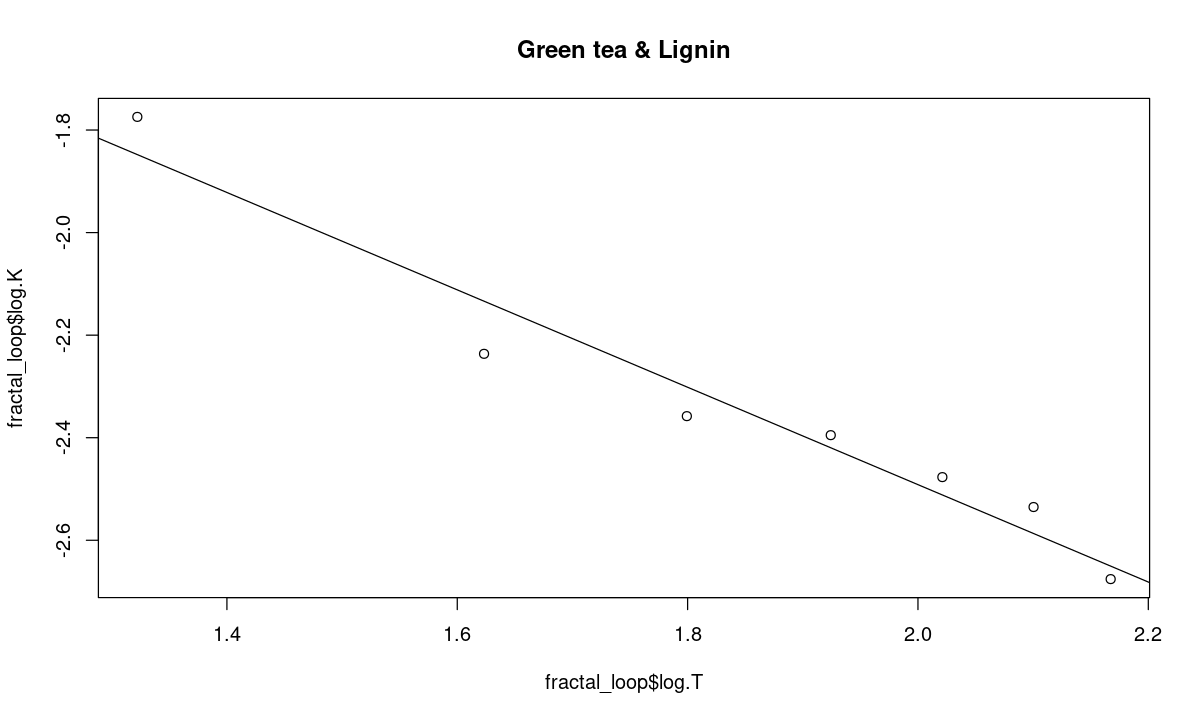

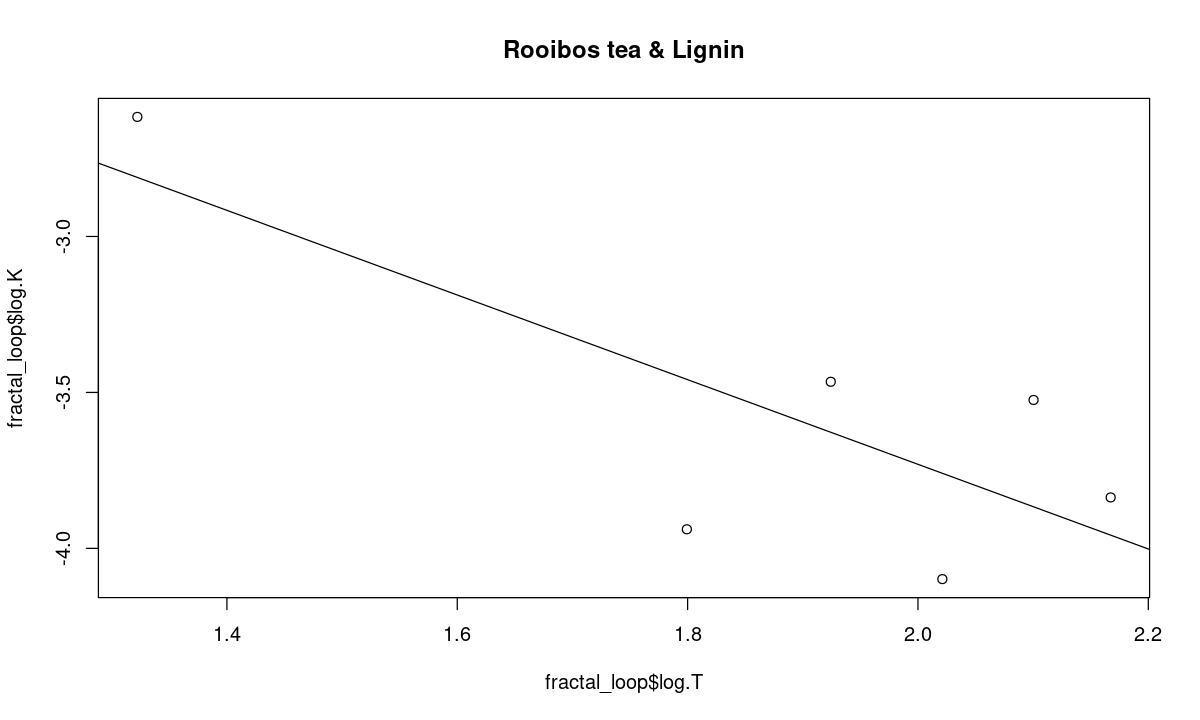

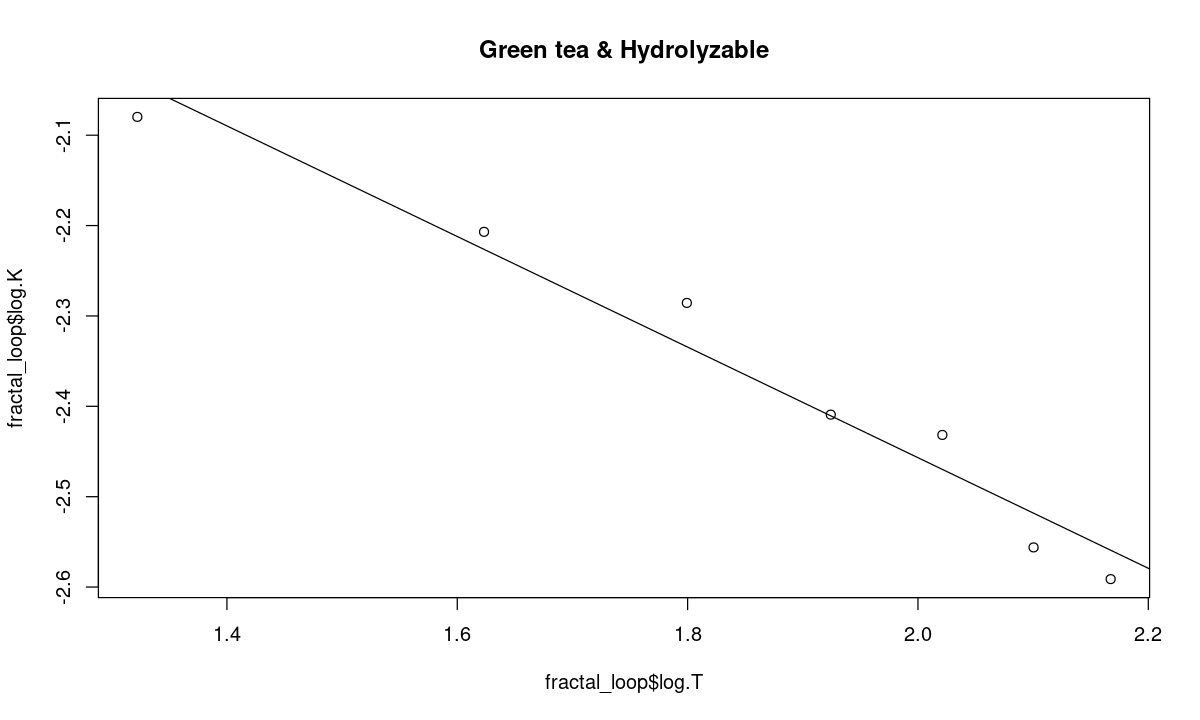

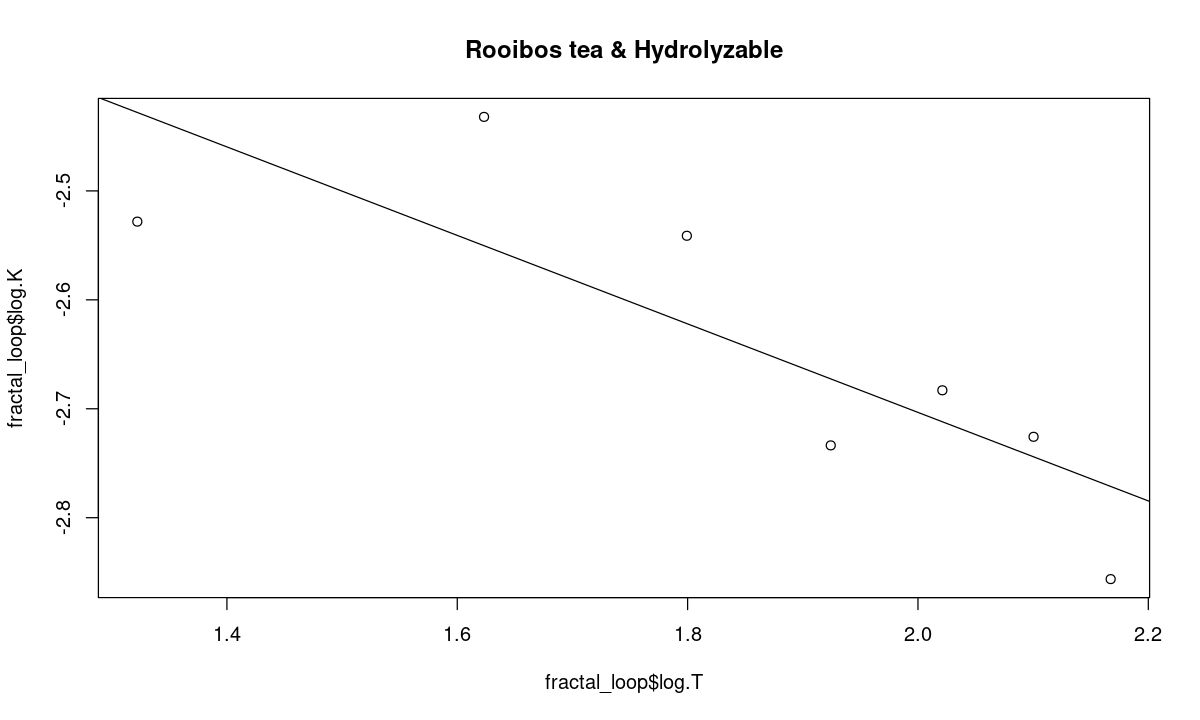

In [101]:
for (i in 1:nrow(fractal_biochemical_kinetics)) {
    
    fractal_loop <- data_median_fractal_biochemical %>%
      filter((`Biomass type` == fractal_biochemical_kinetics$Biomass_type[i]) &
             (`Biochemical composition` == fractal_biochemical_kinetics$Biochemical_composition[i])) 
    
    lm_fractal <- lm(`log.K` ~ `log.T`, data = fractal_loop)

    fractal_biochemical_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_biochemical_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_biochemical_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared

    plot(fractal_loop$log.T, fractal_loop$log.K,
         main = paste(fractal_biochemical_kinetics$Biomass_type[i],
                      "&",
                      fractal_biochemical_kinetics$Biochemical_composition[i]))
    abline(a = fractal_biochemical_kinetics$intercept[i], b = fractal_biochemical_kinetics$slope[i])

    
}

In [102]:
fractal_biochemical_kinetics

Biomass_type,Biochemical_composition,intercept,slope,r_sq
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Green tea,Lignin,-0.5924339,-0.9495719,0.9516462
Rooibos tea,Lignin,-1.0164253,-1.3570685,0.6150621
Green tea,Hydrolyzable,-1.2330595,-0.6119060,0.9610390
Rooibos tea,Hydrolyzable,-1.8910531,-0.4061517,0.6724302


In [80]:
fractal_biochemical_kinetics <-  fractal_biochemical_kinetics %>%
  mutate(h = -slope,
         k1 = 10^intercept)
fractal_biochemical_kinetics

Biomass_type,Biochemical_composition,intercept,slope,r_sq,h,k1
Green tea,Lignin,-0.5924339,-0.9495719,0.9516462,0.9495719,0.25560310
Rooibos tea,Lignin,-1.0164253,-1.3570685,0.6150621,1.3570685,0.09628857
Green tea,Hydrolyzable,-1.2330595,-0.6119060,0.9610390,0.6119060,0.05847100
Rooibos tea,Hydrolyzable,-1.8910531,-0.4061517,0.6724302,0.4061517,0.01285130


In [81]:
data_LIC_rooibos <- subset(data_fractal, `Biomass type` == "Rooibos tea"  & `Biochemical composition` == "Lignin" )

H_LIC_Rooibos = 0
P_LIC_Rooibos = 1- H_LIC_Rooibos

data_LIC_rooibos <- data_LIC_rooibos %>%
                mutate(Time = (`Sampling period (days)`) ** P_LIC_Rooibos)%>%
                select(`Sampling period (days)`, Time, `Log ratio LIC`, `Biomass type`)%>%
                rename(Log = `Log ratio LIC`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_LIC_rooibos <- rbind(data_LIC_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Rooibos tea")) 

data_median_LIC_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_LIC_rooibos, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_LIC_rooibos))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_LIC_rooibos))[1]
R.squared = summary(lm(Log ~ Time, data_median_LIC_rooibos))$r.squared
R.squared
Slope
Intercept

ERROR: Error in eval(e, x, parent.frame()): objet 'Biomass type' introuvable


### 13.5.2 Fractal of Rooibos tea Hydrolyzable content 

`H_Hydro_Rooibos = 0.5`

In [ ]:
data_Hydro_rooibos <- subset(data_fractal, `Biomass type` == "Rooibos tea"  & `Biochemical composition` == "Hydrolyzable" )

H_Hydro_Rooibos = 0.5
P_Hydro_Rooibos = 1- H_Hydro_Rooibos

data_Hydro_rooibos <- data_Hydro_rooibos %>%
                mutate(Time = (`Sampling period (days)`) ** P_Hydro_Rooibos)%>%
                select(`Sampling period (days)`, Time, `Log ratio Hydrolyzable`, `Biomass type`)%>%
                rename(Log = `Log ratio Hydrolyzable`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_Hydro_rooibos <- rbind(data_Hydro_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Rooibos tea")) 

data_median_Hydro_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_Hydro_rooibos, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_Hydro_rooibos))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_Hydro_rooibos))[1]
R.squared = summary(lm(Log ~ Time, data_median_Hydro_rooibos))$r.squared
R.squared
Slope
Intercept

### 13.5.3 Fractal of Green tea Lignin content

`H_LIC_Green = 0.96`

In [ ]:
data_LIC_Green <- subset(data_fractal, `Biomass type` == "Green tea"  & `Biochemical composition` == "Lignin" )

H_LIC_Green = 0.96
P_LIC_Green = 1- H_LIC_Green

data_LIC_Green <- data_LIC_Green %>%
                mutate(Time = (`Sampling period (days)`) ** P_LIC_Green)%>%
                select(`Sampling period (days)`, Time, `Log ratio LIC`, `Biomass type`)%>%
                rename(Log = `Log ratio LIC`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_LIC_Green <- rbind(data_LIC_Green, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Green tea")) 

data_median_LIC_Green <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_LIC_Green, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_LIC_Green))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_LIC_Green))[1]
R.squared = summary(lm(Log ~ Time, data_median_LIC_Green))$r.squared
R.squared
Slope
Intercept

### 13.5.4 Fractal of Green tea Hydrolyzable content 

`H_Hydro_Green = 0.7`

In [ ]:
data_Hydro_Green <- subset(data_fractal, `Biomass type` == "Green tea"  & `Biochemical composition` == "Hydrolyzable" )

H_Hydro_Green = 0.7
P_Hydro_Green = 1- H_Hydro_Green

data_Hydro_Green <- data_Hydro_Green %>%
                mutate(Time = (`Sampling period (days)`) ** P_Hydro_Green)%>%
                select(`Sampling period (days)`, Time, `Log ratio Hydrolyzable`, `Biomass type`)%>%
                rename(Log = `Log ratio Hydrolyzable`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_Hydro_Green <- rbind(data_Hydro_Green, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Green tea")) 

data_median_Hydro_Green <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_Hydro_Green, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_Hydro_Green))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_Hydro_Green))[1]
R.squared = summary(lm(Log ~ Time, data_median_Hydro_Green))$r.squared
R.squared
Slope
Intercept